In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def is_complete_dot_bracket(dot_bracket):
    stack = []

    for char in dot_bracket:
        if char == '(':
            stack.append(char)
        elif char == ')':
            if not stack:
                return False
            stack.pop()

    return len(stack) == 0

In [24]:
def dot_bracket_to_matrix(dot_bracket):
    stack = []
    pairing_matrix = np.zeros((len(dot_bracket), len(dot_bracket)))

    for i, char in enumerate(dot_bracket):
        if char == '(':
          stack.append(i)
        elif char == ')':
          if stack:
            j = stack.pop()
            pairing_matrix[i, j] = 1
            pairing_matrix[j, i] = 1

    return pairing_matrix

In [39]:
def compute_mFMI(pred_matrix, target_matrix, threshold=0.5):

    TP = np.sum(pred_matrix * target_matrix)
    prod_true = np.sum(pred_matrix) * np.sum(target_matrix)
    if prod_true > 0:
        FMI = TP / np.sqrt(prod_true)
    else:
        FMI = 0

    u = (
        np.sum(
            (~np.sum(pred_matrix, axis=1).astype(bool))
            * (~np.sum(target_matrix, axis=1).astype(bool))
        )
        / pred_matrix.shape[0]
    )

    mFMI = u + (1 - u) * FMI

    return mFMI

In [ ]:
def read_ct_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    num_bases = int(lines[0].split()[0])
    title = lines[0].split()[1]

    structures = []
    current_structure = []

    for line in lines[1:]:
        # Skip empty lines
        if not line.strip():
            continue

        # Parse the information about a base
        base_info = line.split()
        base_number = int(base_info[0])
        base = base_info[1]
        index_prev = int(base_info[2])
        index_next = int(base_info[3])
        paired_base_number = int(base_info[4])

        # Store the information in a dictionary
        base_data = {
            "base_number": base_number,
            "base": base,
            "index_prev": index_prev,
            "index_next": index_next,
            "paired_base_number": paired_base_number
        }

        current_structure.append(base_data)

    structures.append({
        "num_bases": num_bases,
        "title": title,
        "base_info": current_structure
    })

    return structures

In [ ]:
def ct_to_secondary_structure_string(file_path):
    structures = read_ct_file(file_path)

    secondary_structure_strings = []
    seq = ''
    for structure in structures:
        num_bases = structure["num_bases"]
        base_info = structure["base_info"]


        structure_string = ['.' for _ in range(num_bases)]


        for base_data in base_info:
            seq+=base_data["base"]
            base_number = base_data["base_number"]
            paired_base_number = base_data["paired_base_number"]

            if paired_base_number != 0 and base_number < paired_base_number:
                structure_string[base_number - 1] = '('
                structure_string[paired_base_number - 1] = ')'

        secondary_structure_strings.append(''.join(structure_string))

    return secondary_structure_strings, seq


In [ ]:
from sklearn.metrics import f1_score

def hammingDist(str1, str2):
    i = 0
    count = 0

    while(i < len(str1)):
        if(str1[i] != str2[i]):
            count += 1
        i += 1
    return count

def split_string(input_string, chunk_size):
    return [input_string[i:i + chunk_size] for i in range(0, len(input_string), chunk_size)]


In [ ]:
def split_sequence_and_dot_bracket(sequence, dot_bracket, min_chunk_size):
    subparts_sequence = []
    subparts_dot_bracket = []
    current_part_sequence = ""
    current_part_dot_bracket = ""

    for seq_char, dot_char in zip(sequence, dot_bracket):
        current_part_sequence += seq_char
        current_part_dot_bracket += dot_char

        if dot_char == ')':
            if is_complete_dot_bracket(current_part_dot_bracket) and len(current_part_dot_bracket) >= min_chunk_size:
                subparts_sequence.append(current_part_sequence)
                subparts_dot_bracket.append(current_part_dot_bracket)
                current_part_sequence = ""
                current_part_dot_bracket = ""

    return subparts_sequence, subparts_dot_bracket

# SARS dot bracket comparison

## Comparing from 10.1261/rna.076141.120 and doi.org/10.1038/s41467-022-28603-2. The first paper has purely in silico predicted secondary structures. The second paper uses chemical probing to inform structure. I use all secondary structures predicted in silico over 120 bp window and compare that to the chemically informed structure over the same window using F1 score. If the f1 score is >0.9 I include it in the dataset.

In [81]:
das_df = pd.read_excel('Book2.xlsx')
das_df[:8]

,Interval start,Interval end,Sequence,Secondary structure,z-score,P
0,1,120,AUUAAAGGUUUAUACCUUCCCAGGUAACAAACCAACCAACUUUCGA...,......(((((.(((((....)))))..)))))...........((...,-2.13,0.654132
1,41,158,UUUCGAUCUCUUGUAGAUCUGUUCUCUAAACGAACUUUAAAAUCUG...,....(((((.....))))).........(((((..........(((...,-2.91,0.998151
2,81,198,AAUCUGUGUGGCUGUCACUCGGCUGCAUGCUUAGUGCACUCACGCA...,...(((((((..((.((((.(((.....))).))))))..))))))...,-0.80,0.989529
3,121,238,CACGCAGUAUAAUUAAUAACUAAUUACUGUCGUUGACAGGACACGA...,...((((((..((((.....)))))))))).((((((((((.((((...,-2.33,0.989119
4,159,278,GGACACGAGUAACUCGUCUAUCUUCUGCAGGCUGCUUACGGUUUCG...,.....((((...(((.((((((((.....((((((.(((((........,-2.87,0.995523
5,319,438,GCCUGUUUUACAGGUUCGCGACGUGCUCGUACGUGGCUUUGGAGAC...,.....((((((((((.(((((.((((..(.(((((.((((((((((...,-2.56,0.632105
6,399,518,AUCUUAAAGAUGGCACUUGUGGCUUAGUAGAAGUUGAAAAAGGCGU...,........((((((((.((.((((..((..(((((((....(((.....,-1.66,0.621726
7,639,758,AGAACGGUAAUAAAGGAGCUGGUGGCCAUAGUUACGGCGCCGAUCU...,....((((....(((((..(((((.(((.((((.((.((((........,-2.15,0.682640


In [82]:
file_path = 'SARS.ct'
secondary_structure_strings, seq = ct_to_secondary_structure_string(file_path)

for idx, structure_string in enumerate(secondary_structure_strings, start=1):
    print(f"SARS Structure:", structure_string)

SARS Structure: ......(((((.(((((....)))))..)))))...........(((((.....))))).((((.......))))........((((((((.((.((((.(((.....))).)))))).))))))))......................(((((((((((..(((((...(((.(((((((.(((..((((((.(((((......)))))..))))))......)))(((((((.((......)))))))))(((....))).)))))))))).))))).))))...))))))).......((((((...........((((((...))))))....)))))).....(((((.(((((((((((((.....))).)))))..))))).)))))............((((((((.((.((((......(((((((....(((.....))))))))))....)))).)).))).)))))...(((..((((((((((.(((((((......(((.........)))...))).))))...)))..)))))))...)))......((((((((.((((.(((((..(((.(((......)))))).))))))))).))))))))...((((((......)))))).......(((((..(((((.(((.((((.((.((((.......((((....))))..)))).)))))))))))))).)))))...............................((((((((((((((((..((((...((((....))))....))))...))))).)))).))))))).((........))...((((.....))))........((((((((..(((.....(((((....))))).....))).)))))))).(((((......)))))................(((((((...((((..(((((.((..(((((......))))).

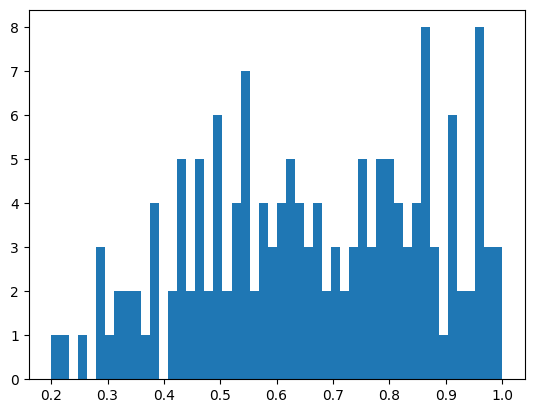

In [91]:
gold_std = {}
gold_std['SARS'] = {}
dist = []
ind_added = []

# Iterate over rows in pairs
for ind in range(0, len(das_df), 2):
    row1 = das_df.iloc[ind]
    row2 = das_df.iloc[ind + 1]

    start1, end1 = row1['Interval start'], row1['Interval end']
    substring1 = structure_string[start1 - 1:end1]
    seq_sub1 = seq[start1:end1 + 1]

    start2, end2 = row2['Interval start'], row2['Interval end']
    substring2 = structure_string[start2 - 1:end2]
    seq_sub2 = seq[start2:end2 + 1]
    if start2 > end1:
      struct1 = row1['Secondary structure']
      struct2= row2['Secondary structure']
      substring1 = structure_string[start1 - 1:end1]
      substring2 = structure_string[start2 - 1:end2]
      seq_sub1 = seq[start1:end1 + 1]
      seq_sub2 = seq[start2:end2 + 1]

      pair_target = dot_bracket_to_matrix(struct1)
      pair_test = dot_bracket_to_matrix(substring1)

      # Compute F1 score
      mFMI = compute_mFMI(pair_target, pair_test)
      dist.append(mFMI)

      if mFMI >= 0.9:
        ind_added.extend([ind])
        gold_std['SARS'][seq_sub1] = struct1

      pair_target = dot_bracket_to_matrix(struct2)
      pair_test = dot_bracket_to_matrix(substring2)

      # Compute F1 score
      mFMI = compute_mFMI(pair_target, pair_test)
      dist.append(mFMI)

      if mFMI >= 0.9:
        ind_added.extend([ind])
        gold_std['SARS'][seq_sub2] = struct2

    else:
      long_struct_target = row1['Secondary structure'][:start2-start1-1] + row1['Secondary structure'][start2-start1:] + row2['Secondary structure'][end1-end2-1:]
      long_struct = structure_string[start1 - 1:end2]
      seq_sub = seq[start1:end2 + 1]
      # Calculate MCC for each pair
      pair_target = dot_bracket_to_matrix(long_struct_target)
      pair_test = dot_bracket_to_matrix(long_struct)

      # Compute F1 score
      mFMI = compute_mFMI(pair_target, pair_test)
      # Append MCC values to the dist list
      dist.append(mFMI)
      long_seq_sub = seq[start1:end2+1]
      # Check if MCC is greater than or equal to 0.8 for both pairs
      if mFMI >= 0.9:
        ind_added.extend([ind])
        gold_std['SARS'][long_seq_sub] = long_struct_target

# Plot the histogram
plt.hist(dist, bins=50)
plt.show()

In [88]:
len(dist)

157

In [92]:
len(gold_std['SARS'])

24

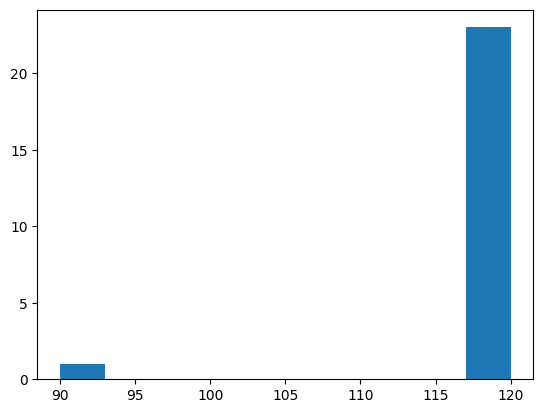

In [93]:
lens = []
for k,v in gold_std['SARS'].items():
    lens.append(len(k))
plt.hist(lens)
plt.show()

# XIST Analysis

## From https://doi.org/10.1073/pnas.1600008113. In this paper they looked at chemical probing and in silico models for Xist in Mouse. In their supplement they also looked at other established models and identified regions of high agreement. We use their analysis comparing to other models and take pull regions of high agreement from their secondary structure model.

In [67]:
#regions of high agreement
conserved_xist = [[873,1009],[6278,6371],[6473,6574],[7064,7173],[9788,9846],[13883,14509],[15775,16119]]

In [68]:
file_path = 'XIST_ThreeReagent_fold.ct'
secondary_structure_strings, seq = ct_to_secondary_structure_string(file_path)

for idx, structure_string in enumerate(secondary_structure_strings, start=1):
    print(f"XIST Structure:", structure_string)

XIST Structure: .((((......))))...............(((.((((.((((((...(((((((((((.((((......))))...(((((((((.......))))))))).....(((((....))))).........(((((((((((((..(...........)..))))))))))))).((((((((.(........)....((((.((((((........................(((((((.....................................))))))).(......).)))))).))))..........................))))))).)..))))))))))).))).))).)))).(((((....((((.((((....))))..)))).....................(((((((((.......((((((((.........((((...(((((((.(((..........................))).)))))))...))))(((((...............)))))))))))))))))................(((((....))))).((........))...............))))).....)))))...)))........................((((((((.(..(((.....((((((((((.....................)))))))))).(((.((((((.((((((((.......(((..(((((....)))))..))).....))))))..))........(((........))).((.....))..)))))).)))............)))..))))))).))....((((.......)))).(((((((.((((((((.....))))))))(((.....)))(((((((((((..((((.......)))).))))))).).)))...)))))))....(((.(((((...(((.

In [69]:
pgen_gold_std = {}
pgen_gold_std['XIST_mus'] = {}
for r in conserved_xist:
  sub = structure_string[r[0]:r[1]]
  seq_sub = seq[r[0]:r[1]]
  pgen_gold_std['XIST_mus'][seq_sub] = sub

7


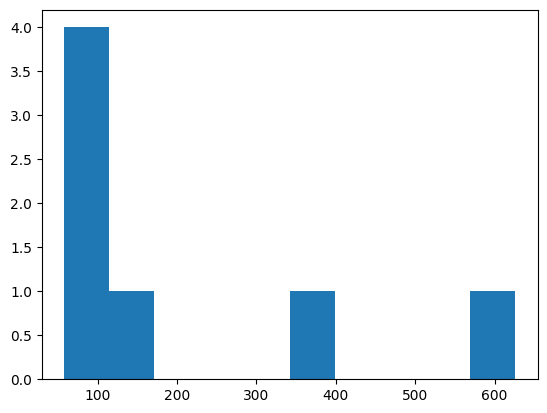

In [95]:
lens = []
for k,v in pgen_gold_std['XIST_mus'].items():
    lens.append(len(k))
print(len(lens))
plt.hist(lens)
plt.show()

# MALAT Structures

# This dataset was used in this paper: 10.1261/rna.079388.122 . In this paper they compiled data from SHAPE-MaP and a gene-specific primer amplification strategy to examine the full-length MALAT1 structure in cells and cell-free, in two cell types, and across two species (African green monkey and human). Their results show a high correlation in shape and they subset their data to high confidence regions R^2 > 0.8 across all replicates. We take those regions of high agreement from their analyses.

In [96]:
import os

txt_files = [f for f in os.listdir('.') if f.endswith('.ct')]
txt_files
malat_gold_std = {}
malat_gold_std['malat'] = {}
for f in txt_files:
    if 'SARS' in f or 'XIST' in f:
        continue
    else:
      secondary_structure_strings, seq = ct_to_secondary_structure_string(f)
      print(len(seq) == len(secondary_structure_strings[0]))
      print(is_complete_dot_bracket(secondary_structure_strings[0]))
      malat_gold_std['malat'][seq] = secondary_structure_strings[0]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


12


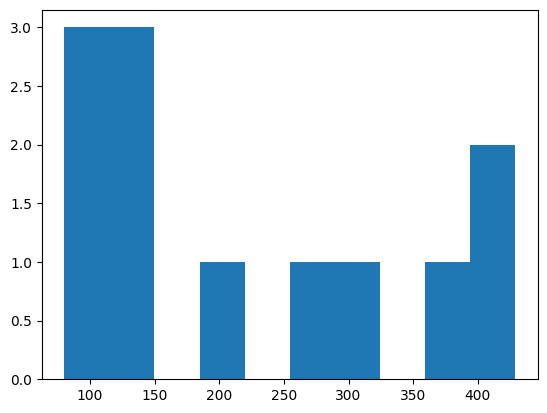

In [97]:
lens = []
for k,v in malat_gold_std['malat'].items():
    lens.append(len(k))
print(len(lens))
plt.hist(lens)
plt.show()

# Structures and seq subsetting from full lnegth ncRNA

From 10.1093/bib/bbac205. In this paper they curated secondary structures from literature. Looking at papers similar to the ones above. I am taking all lncRNA structureal models from their dataset that are supported by at least two measurement techniques. These are full length structural models. I subset each model into by a window of 200 bp and search for full dot brackets within these models.

In [107]:
#>ROX2
seq = 'TGTTGCGGCATTCGCGGCCTGGTCACACTAAGCTAGGGCTACTTTTTATATCATAAGTCGAGCGTTTAGGTAGCTCGGATGGCCATCGAAAGGGTAAATTGGTGTTACATATAGCTTTAGAGATCGTTTCGAATCACATTGATAATCGTTCGAAACGTTCTCCGAAGCAAAATCAAGCAAGAGTAACGATTTCCGCATAGTCGAAAATGTTTAAGTTGAATTGTCTTACGGACAGTGAGATGAGTACGACTATTTGGAAATCACAAACGAATTGTTTTCATGGTTGACGCGCTTGTCAAGCTACAAAACAAAATGAATGATATACAATATACAATATACAATATGCAATACAATACAATACAAGACAAAAAAATGTGTCTTGGAACGCAACATTGTACAAGTCGCAATGCAAACTGAAGTCTTAAAAGACGTGTAAAATGTTGCAAATTAAGCAAATATATATGCATATATGGGTAACGTTTTACGCGCCTTAACCAGTCAAAATACAAAATAAATTGGTAAATTTCATATAACTAGTGAAATGTTATACGAAACTTAACAATTGCCAAATAA'
struct = '.................................................................................................................(((((.((((.((((((((((.............)))))))))).)))).)))))...................((((((((.(((((((...........(((..(((((((...)))))))..))).....))))))).)))))))).........(((((((...((((((((....)))))).))..))))))).................................................(((((((........)))))))........((((((.......))))))................(((.(((((((((((((((....((.(((........))).)).....))))))))))))))).)))......................((((.(((.((((.((((((.........)))))).)))).))).))))...........'

#>HOTAIR
hotair_seq = 'GACUCGCCUGUGCUCUGGAGCUUGAUCCGAAAGCUUCCACAGUGAGGACUGCUCCGUGGGGGUAAGAGAGCACCAGGCACUGAGGCCUGGGAGUUCCACAGACCAACACCCCUGCUCCUGGCGGCUCCCACCCGGGGCUUAGACCCUCAGGUCCCUAAUAUCCCGGAGGUGCUCUCAAUCAGAAAGGUCCUGCUCCGCUUCGCAGUGGAAUGGAACGGAUUUAGAAGCCUGCAGUAGGGGAGUGGGGAGUGGAGAGAGGGAGCCCAGAGUUACAGACGGCGGCGAGAGGAAGGAGGGGCGUCUUUAUUUUUUUAAGGCCCCAAAGAGUCUGAUGUUUACAAGACCAGAAAUGCCACGGCCGCGUCCUGGCAGAGAAAAGGCUGAAAUGGAGGACCGGCGCCUUCCUUAUAAGUAUGCACAUUGGCGAGAGAAUUAAGUGCUGCAACCUAAACCAGCAAUUACACCCAAGCUCGUUGGGGCCUAAGCCAGUACCGACCUGGUAGAAAAAGCAACCACGAAGCUAGAGAGAGGAGCCAGAGGAGGGAAGAGAGCGCCAGACGAAGGUGAAAGCGAACCACGCAGAGAAAUGCAGGCAAGGGAGCAAGGCGGCAGUUCCCGGAACAAACGUGGCAGAGGGCAAGACGGGCACUCACAGACAGAGGUUUAUGUAUUUUUAUUUUUUAAAAUCUGAUUUGGUGUUCCAUGAGGAAAAGGGAAAAUCUAGGGAACGGGAGUACAGAGAGAAUAAUCCGGGUCCUAGCUCGCCACAUGAACGCCCAGAGAACGCUGGAAAAACCUGAGCGGGUGCCGGGGCAGCACCCGGCUCGGGUCAGCCACUGCCCCACACCGGGCCCACCAAGCCCCGCCCCUCGCGGCCACCGGGGCUUCCUUGCUCUUCUUAUCAUCUCCAUCUUUAUGAUGAGGCUUGUUAACAAGACCAGAGAGCUGGCCAAGCACCUCUAUCUCAGCCGCGCCCGCUCAGCCGAGCAGCGGUCGGUGGGGGGACUGGGAGGCGCUAAUUAAUUGAUUCCUUUGGACUGUAAAAUAUGGCGGCGUCUACACGGAACCCAUGGACUCAUAAACAAUAUAUCUGUUGGGCGUGAGUGCACUGUCUCUCAAAUAAUUUUUCCAUAGGCAAAUGUCAGAGGGUUCUGGAUUUUUAGUUGCUAAGGAAAGAUCCAAAUGGGACCAAUUUUAGGAGGCCCAAACAGAGUCCGUUCAGUGUCAGAAAAUGCUUCCCCAAAGGGUUGGCAGUGUGUUUUGUUGGAAAAAAGCUUGGGUUAUAGGAAAGCCUUUCCCUGCUACUUGUGUAGACCCAGCCCAAUUUAAGAAUUACAAGGAAGCGAAGGGGUUGUGUAGGCCGGAAGCCUCUCUGUCCCGGCUGGAUGCAGGGGACUUGAGCUGCUCCGGAAUUUGAGAGGAACAUAGAAGCAAAGGUCCAGCCUUUGCUUCGUGCUGAUUCCUAGACUUAAGAUUCAAAAACAAAUUUUUAAAAGUGAAACCAGCCCUAGCCUUGCCUUUGGAAGCUCUUGAAGGUUCAGCACCCACCCAGGAAUCCACCUGCCUGUUACACGCCUCUCCAAGACACAGUGGCACCGCUUUUCUAACUGGCAGCACAGAGCAACUCUAUAAUAUGCUUAUAUUAGGUCUAGAAGAAUGCAUCUUGAGACACAUGGGUAACCUAAUUAUAUAAUGCUUGUUCCAUACAGGAGUGAUUAUGCAGUGGGACCCUGCUGCAAACGGGACUUUGCACUCUAAAUAUAGGCCCCAGCUUGGGACAAAAGUUGCAGUAGAAAAAUAGACAUAGGAGAACACUUAAAUAAGUGAUGCAUGUAGACACAGAAGGGGUAUUUAAAAGACAGAAAUAAUAGAAGUACAGAAGAACAGAAAAAAAAUCAGCAGAUGGAGAUUACCAUUCCCAAUGCCUGAACUUCCUCCUGCUAUUAAGAUUGCUAGAGAAUUGUGUCUUAAACAGUUCAUGAACCCAGAAGAACGCAAUUUCAAUGUAUUUAGUACACACACAGUAUGUAUAUAAACACAACUCACAGAAUAUAUUUUCCAUACAUUGGGUAGGUAUGCACUUUGUGUAUAUAUAAUAAUGUAUUUUCCAUGCAGUUUUAAAAUGUAGAUAUAUUAAUAUCUGGAUGCAUUUUC'
hotair_struct = '..((((((.(((((((((.(((...(((....((((((((...(((.....))).))))))))......((.((((((......))))))..)).((((...((.((.((((((((...((((((.((...((((((....((((....)))).......)))))).)).))).............((.(((.((((((....)))))).))).))..........)))...)))))))).))))...)))).....)))))))))))).........(((((..((((((((.(((((..(((.........)))))))).....((((..(((((.(.((.((.....(((((.(((...))).))))).......))))))))))..)))).....))))))))....)).))).))).)))))).........(((((..........)))))..........((((((.(((.((....(((((.......))))).......))..))))).)))).........(((((((((((.......((((((..............(((.....)))........((((((..((((((((((.(((....(((((.((....))(((((.(((...........)))....(((........))).................((((....((((((.((((.((............((((((..(((..................)))..))))))....)).))))))))))))))....((((.....((((((((((((((.......)))))).))))))))))))..))))).......((((.......)))).(((......)))..)))))))).))))))))))....(((((...........))))).))))))........((((....))))((.((..((((((((...(((((....((((....)))).))))).))))))))..)).)).))))))..........))))))))).)).........(((....(((((((.((((....((((((..............((((((((...........(((((.......((((((((...(((((...(((((....)))))........)))))..))))))))......)))))............))))).))))))))))))).)))).)))....((((((.....(((((((.(((...((((....))))...))).(((....(((....)))..)))..((((....))))..)))))))................))))))...(((((((.((...((((.(((..(((.(((((.((.....))..)))))..)))..)))))))........(((((((..(((((((((((...)))))))))))....)).)))))....................................))))))))).)))..((.((((((.((((((...(((((((((......(((((..((((.((..((((..............)))))))))).(((.(((((....((.((((((....((((((....................(((((..(((.(((((((((......(((((((..............))))))).((.....))........((((((((....))))))))..)))))...)))).))).....)))))((((...)))).....))))))........................(((((....))))).))).)))))....))))).))).....................(((((.(((.......((.......)).(((..(((.((.......))))).)))))).))))).)))))..........))))...(((((((.......)))))))..)))))...))))..)).........((.....(((((.((...)).)))))......)).(((((.....................)))))..((((((((...)))))))).((.((((((((((..(((...........))).)))))))))).)))))))).))......'

#>RepA
rep_a_seq = 'CCCAUCGGGGCCACGGAUACCUGUGUGUCCUCCCCGCCAUUCCAUGCCCAACGGGGUUUUGGAUACUUACCUGCCUUUUCAUUCUUUUUUUUUCUUAUUAUUUUUUUUUCUAAACUUGCCCAUCUGGGCUGUGGAUACCUGCUUUUAUUCUUUUUUUCUUCUCCUUAGCCCAUCGGGGCCAUGGAUACCUGCUUUUUGUAAAAAAAAAAAAAAAAAAAAAAAAACCUUUCUCGGUCCAUCGGGACCUCGGAUACCUGCGUUUAGUCUUUUUUUCCCAUGCCCAACGGGGCCUCGGAUACCUGCUGUUAUUAUUUUUUUUUCUUUUUCUUUUGCCCAUCGGGGCUGUGGAUACCUGCUUUAAAUUUUUUUUUUCACGGCCCAACGGGGCGCUUGGUGGAUGGAAAUAUGGUUUUGUGAGUUAUUGCACUACCUGGAAUAUCUAUGCCUCUUAUUUGCGUGUACUGUUGCUGCUGAUCGUUUGGUGCUGUGUGAGUGAACCUAUGGCUUAGAAAAACGACUUUGCUCUUAAACUGAGUGGGUGUUCAGGGCGUGGAGAGCCCGCGUCCGCCAUUAUGGCUUCUGCGUGAUACGGCUAUUCUCGAGCCAGUUACGCCAAGAAUUAGGACACCGAGGAGCACAGCGGACUGGAUAAAAGCAACCAAUUGCGCUGCGCUAGCUAAAGGCUUUCUUUAUAUGUGCGGGGUUGCGGGAUUCGCCUUGAUUUGUGGUAGCAUUUGCGGGGUUGUGCUAGCCGGAAGUAGAAAGCCAAGGAGUGCUCGUAUUAGUGUGCGGUGUUGCGCGGAAGCCGCAGAGGACUAGGGGAUAGGGCUCAGCGUGGGUGUGGGGAUUGGGCAGGGUGUGUGUGCAUAUGGACCCCUGGCGCGGUCCCCCGUGGCUUUAAGGGCUGCUCAGAAGUCUAUAAAAUGGCGGCUCGGGGGCUCCACCCGAGGCUCGACAGCCCAAUCUUUGUUCUGGUGUGUAGCAAUGGAUUAUAGGACAUUUAGGUCGUACAGGAAAAGAUGGCGGCUCAAGUUCUUGGUGCGGUAUAACGCAAAGGGCUUUGUGUGUCACAUGUCAGCUUCAUGUCUGAGUUAGCCUGGAGAGGUGGCACAUGCUCUUGAAUGUGUCUAAGAUGGCGGAAGUCAUGUGACCUGCCCUCUAGUGGUUUCUUUCAGUGAUUUUUUUUUUGGCGGGCUUUAGCUACUUGGCGGGCUUUGCCCGAGGGUACACUUGGUGCAUUAUGGUAGGGUGUGGUUGGUCCUACCUUGUGCCACUCGAAGCUGAGGCAAGGCUAAGUGGAAGUGUUGGUUGCCACUUGACGUAACUCGUCAGAAAUGGGCACAAGUGUGAAAGUGUUGGUGUUUGCUUGACUUCCAGUUAGAAAUGUGCAUUAUUGCUUGGUGGCCAGGAUGGAAUUAGACUGUGAUGAGUCACUGUCCCAUAAGGACGUGAGUUUCGCUUGGUACUUCACGUGUGUCUUUAGUCAUCAUUUUUUCGAAGUGCCUGCCCAGGUCGGGAGAGCGCAUGCUUGCAAUUCUAACACUGAAGUGUUGGAUGAUGUCGGAUCCGAUUCGAGAGACCGAGGCUGCGGGUUCUUGGUCGAUGUAAAUCAUUGAAACCUCACCUAUUA'
rep_a_struct = '.....(((((....((((((....)))))).)))))....((((.((((....))))..)))).((((((..(((((((((((((((((((((.......(((((((((........((((...(((((((.(((..........................))).)))))))...))))((.((...))))........))))))))))))))))))...............(((((....))))).(((....)))...............(((...((((....))))...))).(((.((............................((((....((((((((((.....................))))))))))....))))))..))))))))))))...)))...))))))..((((((((((.((((((.(((..((((.....((((.((.(((.(((.((..(((((.....((((((((((((..(((.((((((..............((((.......)))).(((((((.((((((((.....))))))))((((...)))).((((((((((..((((.......)))).)))))))..)))....)))))))..((((((((((...(((.......((.((((...((.((((((.((((...))))..........)))))).)).((((...)))).........)))).)).....))).))))))))..)).........)))))))))..))))))))).)))..))))))).))))))..))))))))))..))).((((.(((((((((.((((((.((((((((.((((((.((.(........).)))))).)).))))))))...((((((..((((((((................)))))))).)))))).))))))..))).)..))))).)))).)))))))))).)).)))).......(((((.((((.((((((.((........)))))))).))))))))).((((......)))).(((((.......((((((((...(((((.((((.......((((....))))(((((((........)))))))......)))))))))))))))))..))))).(((((((...((((((((((((........((((((....(((.((((((((((..((((((((......))))).)))....(((((((.........)))))))(((.((((((..(((((((.(((...((((.(((((((....(.((((..((((((.....)))))).....)))))........(((((........))))).))))))).)))).....))).)))..)))))))))))))..............((((..(.((((.((((.....)))))))).).))))..((((((((....(((...........)))......)))))))).))))..))))))..)))....))))))...((((((((....)))))))).(((.....)))((((.(((((..(((......)))..)))))))))....))))))))))))....))).))))'

#>PAN
pan_seq = 'ACUGGGACUGCCCAGUCACCUUGGCUGCCGCUUCACCUAUGGAUUUUGUGCUCGCUGCUUGCCUUCUUGCCGCUUCUGGUUUUCAUUGGUGCCGCCGAUUGUGGGUUGAUUGCGUCGCUUUUGGCAAUAUACCCAUCCUGGCUUUCGGCUAGGUUUUCCGUCCUACUUUUCCCACAUUGGCCUGAGAGCUGUAGUACAAAAAACACCGCGCGGUCUGGAGCUCUCCAUAAGCCCGCAGAACAAAAGCUGCGAUUUGCCCAAAAACCUUGCCAUGGCAACUAUACAGUCACCCCUUGCGGGUUAUUGCAUUGGAUUCAAUCUCCAGGCCAGUUGUAGCCCCCUUUUAUGAUAUGCGAGGAUACUUAACGUGUCUGAAUGUGGAAUAUAAUGUGAAAGGAAAGCAGCGCCCACUGGUGUAUCAGAACAGUGGUGCACUACCUAUCUGCUCAUUCGUUGUUUCGGUUCUGUGUUUGUCUGAUUCUUAGAUAGUGUUGAGGUAAUUCUAGAAAGCGGAUUGAGUGUAAAUCGGGCCACUUUGCCCUAAAUGUGACAAUCUGGAUGUGUAUCUUAUUGGUGCGUUGUGAAGCAUUUUAAAAUGCGUUUUAGAUUGUAUCAGGCUAGUGCUGUAAUGGUGUGUUUAUUUUUCCAGUGUAAGCAAGUCGAUUUGAAUGACAUAGGCGACAAAGUGAGGUGGCAUUUGUCAGAAGUUUCAAAGUCGUGUAAGAACAUUGGACUAAAGUGGUGUGCGGCAGCUGGGAGCGCUCUUUCAAUGUUAAUGUUUUAAUGUGUAUGUUGUGUUGGAAGUUCCAGGCUAAUAUUUGAUGUUUUGCUAGGUUGACUAACGAUGUUUUCUUGUAGGUGAAAGCGUUGUGUAACAAUGAUAACGGUGUUUUGGCUGGGUUUUUCCUUGUUCGCACCGGACACCUCCAGUGACCAGACGGCAAGGUUUUUAUCCCAGUGUAUAUUGGAAAAACAUGUUAUACUUUUGACAAUUUAACGUGCCUAGAGCUCAAAUUAAACUAAUACCAUAACGUAAUGCAACUUACAACAUAAAUAAAGGUCAAUGUUUAAUCCAUA'
pan_struct = '((((((....)))))).((((((((((((((..((((...((.....((((.(((((((..((((..((((((....((((((...(((.(((((((...((((((..(((((..........)))))..))))))..))))....)))((((........)))).............(((..(((((((.(((..........(((....)))))).))))))).....)))(((((........)))))......)))))))))..))...))))...............................(((((.......)))))...............................((((((.....))))))....................))))..))))))).((((((...........)))))).))))..))...(((((.............................................................)))))..............((((......))))........((((((((....(((((......(((((........))))).....)))))...)))))))).................................((((((((........((((((...(((((...((.((........)).))...))))).........)))))).......)))))))).......)))).))))))))).......................((((..(((((((.(((((.(((((...)))))......((((((.(((...((((((......(((((((((((........))))))))))).........(((((.((((((..((((((.....((((((.((....((.(((.....))).))...)))))))).......))))))...........)))))))))))...................)))))))))))))))......................))))).)))).))))))).)))))................'



In [106]:
more_gold_std = {}
more_gold_std['ROX2'] = {}
more_gold_std['hotair'] = {}
more_gold_std['repA'] = {}
more_gold_std['PAN'] = {}

seq_split, struct_split = split_sequence_and_dot_bracket(seq, struct, 200)
for i in range(len(seq_split)):
    print(is_complete_dot_bracket(struct_split[i]))
    more_gold_std['ROX2'][seq_split[i]] = struct_split[i]


seq_split, struct_split = split_sequence_and_dot_bracket(hotair_seq, hotair_struct, 200)
for i in range(len(seq_split)):
    print(is_complete_dot_bracket(struct_split[i]))
    more_gold_std['hotair'][seq_split[i]] = struct_split[i]


seq_split, struct_split = split_sequence_and_dot_bracket(rep_a_seq, rep_a_struct, 200)
for i in range(len(seq_split)):
    print(is_complete_dot_bracket(struct_split[i]))
    more_gold_std['repA'][seq_split[i]] = struct_split[i]


seq_split, struct_split = split_sequence_and_dot_bracket(pan_seq, pan_struct, 200)
for i in range(len(seq_split)):
    print(is_complete_dot_bracket(struct_split[i]))
    more_gold_std['PAN'][seq_split[i]] = struct_split[i]





True
True
True
True
True
True
True
True
True
True


.................................................................................................................(((((.((((.((((((((((.............)))))))))).)))).)))))...................((((((((.(((((((...........(((..(((((((...)))))))..))).....))))))).))))))))

.........(((((((...((((((((....)))))).))..))))))).................................................(((((((........)))))))........((((((.......))))))................(((.(((((((((((((((....((.(((........))).)).....))))))))))))))).)))

..((((((.(((((((((.(((...(((....((((((((...(((.....))).))))))))......((.((((((......))))))..)).((((...((.((.((((((((...((((((.((...((((((....((((....)))).......)))))).)).))).............((.(((.((((((....)))))).))).))..........)))...)))))))).))))...)))).....)))))))))))).........(((((..((((((((.(((((..(((.........)))))))).....((((..(((((.(.((.((.....(((((.(((...))).))))).......))))))))))..)))).....))))))))....)).))).))).))))))

.........(((((..........)))))..........((((((.(((.((....(((((.......))))).

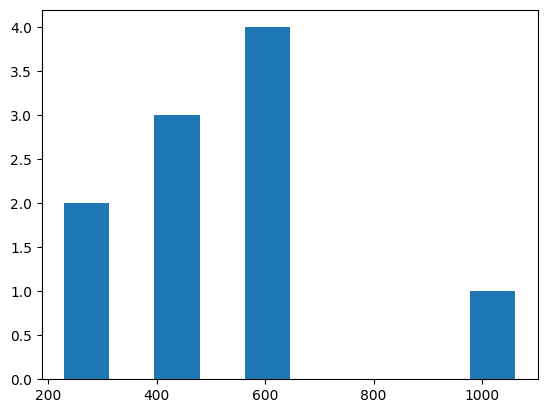

In [109]:
lens = []
for i in more_gold_std.keys():
  for j in more_gold_std[i].keys():
    lens.append(len(more_gold_std[i][j]))
    print(more_gold_std[i][j])
    print()
print(len(lens))
plt.hist(lens)
plt.show()

# Final Dataset

In [110]:

def Merge(dict1, dict2):
  res = {**dict1, **dict2}
  return res

gold_std_full = Merge(gold_std, more_gold_std)
gold_std_full = Merge(gold_std_full, malat_gold_std)
gold_std_full = Merge(gold_std_full, pgen_gold_std)


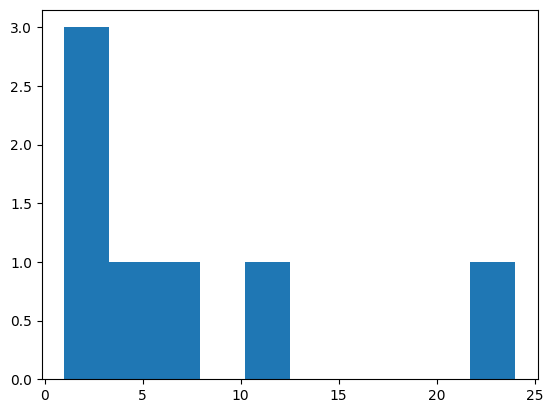

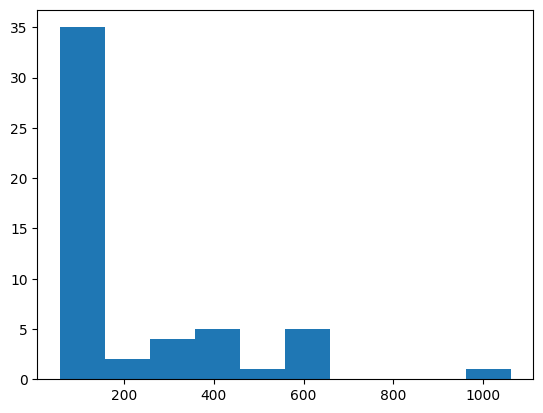

53


In [111]:

lens=[]
seq_lens = []
for i in gold_std_full.keys():
    lens.append(len(gold_std_full[i]))
    for j in gold_std_full[i].keys():
        seq_lens.append(len(gold_std_full[i][j]))
plt.hist(lens)
plt.show()
plt.hist(seq_lens)
plt.show()
print(len(seq_lens))

In [115]:
(np.array(seq_lens) == 600).sum()

0

In [113]:
import json

with open("gold_std.json", "w") as outfile:
    json.dump(gold_std_full, outfile)